**Проект: Линейные модели в машинном обучении**

**Описание проекта**

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее `6000` килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. Он просит разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах.

**Цель проекта**

Нам необходимо создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).
С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Описание данных**

Данные представлены в датасетах:
- `ferma_main.csv`
- `ferma_dad.csv`
- `cow_buy.csv`

1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Описание данных:

| <!-- -->      | <!-- -->        | <!-- -->      |
|:-------------:|:---------------:|:-------------:|
|id|уникальный идентификатор коровы.|
|Удой, кг|масса молока, которую корова даёт в год (в килограммах).|
|ЭКЕ (Энергетическая кормовая единица)|показатель питательности корма коровы.|
|Сырой протеин, г|содержание сырого протеина в корме (в граммах).|
|СПО (Сахаро-протеиновое соотношение)|отношение сахара к протеину в корме коровы.|
|Порода|порода коровы.|
|Тип пастбища|ландшафт лугов, на которых паслась корова.|
|порода папы_быка|порода папы коровы.|
|Жирность,%|содержание жиров в молоке (в процентах).|
|Белок,%|содержание белков в молоке (в процентах).|
|Вкус молока|оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).|
|Возраст|возраст коровы, бинарный признак (менее_2_лет, более_2_лет).|

Признаки в датасете `ferma_main.csv` можно разделить на группы:
- Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
- Характеристики корма: `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г`, `СПО (Сахаро-протеиновое соотношение)`.
- Характеристика пастбища: `Тип пастбища`.
- Характеристики молока: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`.

2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:

| <!-- -->      | <!-- -->        | <!-- -->      |
|:-------------:|:---------------:|:-------------:|
|id|уникальный идентификатор коровы.|
|Имя Папы|имя папы коровы.|

3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:

| <!-- -->      | <!-- -->        | <!-- -->      |
|:-------------:|:---------------:|:-------------:|
|Порода|порода коровы.|
|Тип пастбища|ландшафт лугов, на которых паслась корова.|
|порода папы_быка|порода папы коровы.|
|Имя_папы|имя папы коровы.|
|Текущая_жирность,%|содержание жиров в молоке (в процентах).|
|Текущий_уровень_белок,%|содержание белков в молоке (в процентах).|
|Возраст|возраст коровы, бинарный признак (менее_2_лет, более_2_лет).|

Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей.
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать!

## Загрузка данных

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats as st
import joblib

In [2]:
ferma_main_df = pd.read_csv('/datasets/ferma_main.csv',sep=';')

ferma_main_df.columns = ferma_main_df.columns.map(lambda x: re.sub('\s+', '_', x.lower().strip()))
ferma_main_df.rename(columns = {'удой,_кг' : 'удой',
                              'эке_(энергетическая_кормовая_единица)' : 'эке', 
                              'сырой_протеин,_г' : 'сырой_протеин',
                             'спо_(сахаро-протеиновое_соотношение)' : 'спо',
                             'жирность,%' : 'жирность',
                             'белок,%': 'белок'}, inplace=True)
ferma_main_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [3]:
ferma_dad_df = pd.read_csv('/datasets/ferma_dad.csv', sep=';')

ferma_dad_df.columns = ferma_dad_df.columns.map(lambda x: re.sub('\s+', '_', x.lower().strip()))
ferma_dad_df.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [4]:
cow_buy_df = pd.read_csv('/datasets/cow_buy.csv', sep=';')

cow_buy_df.columns = cow_buy_df.columns.map(lambda x: re.sub('\s+', '_', x.lower().strip()))
cow_buy_df.rename(columns = {'текущая_жирность,%' : 'текущая_жирность',
                              'текущий_уровень_белок,%' : 'текущий_уровень_белок'}, inplace=True)

cow_buy_df.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


##  Предобработка данных

In [5]:
ferma_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                634 non-null    int64 
 1   удой              634 non-null    int64 
 2   эке               634 non-null    object
 3   сырой_протеин     634 non-null    int64 
 4   спо               634 non-null    object
 5   порода            634 non-null    object
 6   тип_пастбища      634 non-null    object
 7   порода_папы_быка  634 non-null    object
 8   жирность          634 non-null    object
 9   белок             634 non-null    object
 10  вкус_молока       634 non-null    object
 11  возраст           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


Сразу можно заметить, что неправильный тип у столбцов `эке`, `спо`, `жирность`, `белок` должен быть тип `float`.
Также удой измеряется в кг, а сырой протеин в г. Приведем к одинаковым единицам измерения

In [6]:
ferma_main_df['эке'].unique()

array(['14,2', '12,8', '14', '12,4', '12,7', '13,2', '14,7', '13,4',
       '13,7', '16,5', '15,4', '14,5', '16', '15,6', '11,5', '15,7',
       '14,3', '15,5', '14,6', '15,9', '15,2', '14,8', '16,4', '11,8',
       '14,4', '16,1', '12,9', '13,8', '13,3', '16,3', '13,9', '14,1',
       '16,7', '15,8', '16,2', '12,2', '14,9', '13,6', '12,5', '16,8',
       '13,5', '15,1', '12,1', '16,6', '15,3', '13,1', '12,3', '11,9',
       '12,6', '15', '13', '12', '11,1', '11,7', '10,9'], dtype=object)

Теперь понятно, почему тип у этоо столбца object. Необходимо заменить запятые на точки.

In [7]:
def change_type(df):
    """
    Преобразует значения в DataFrame в числовой формат.

    Args:
        df (pd.DataFrame): DataFrame с данными, которые нужно преобразовать.

    Returns:
        pd.DataFrame: Измененный DataFrame, в котором:
            - Запятые (`,`) в значениях заменены на точки (`.`).
            - Значения преобразованы в тип `float` (числа с плавающей точкой).
    """
    df = df.str.replace(',', '.')
    df = df.astype('float')
    return df

In [8]:
ferma_main_df['эке'] = change_type(ferma_main_df['эке'])
ferma_main_df['спо'] = change_type(ferma_main_df['спо'])
ferma_main_df['жирность'] = change_type(ferma_main_df['жирность'])
ferma_main_df['белок'] = change_type(ferma_main_df['белок'])

ferma_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой              634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин     634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность          634 non-null    float64
 9   белок             634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Также преобразуем сырой протеин в кг.

In [9]:
ferma_main_df['сырой_протеин'] = ferma_main_df['сырой_протеин'] / 1000

In [10]:
ferma_main_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Исходя из этих данных, можно сделать вывод, что пропусков в таблице нет. Рассмотрим теперь наличие дубликатов.

In [11]:
ferma_main_df['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

В столбце `тип_пастбища` есть два типа, которые описывают одно и то же. Переименуем `Равнинные` в `Равнинное`.

In [12]:
ferma_main_df['тип_пастбища'] = ferma_main_df['тип_пастбища'].replace('Равнинные','Равнинное')
ferma_main_df['тип_пастбища'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

In [13]:
ferma_main_df['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

Аналогичная ситуация и с породой_папы_быка. Переименуем `Айдиалл` в `Айдиал`.

In [14]:
ferma_main_df['порода_папы_быка'] = ferma_main_df['порода_папы_быка'].replace('Айдиалл','Айдиал')
ferma_main_df['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [15]:
ferma_main_df['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Заменим эти значения на значения породы из столбца `порода_папы_быка`

In [16]:
ferma_main_df['порода'] = ferma_main_df['порода'].replace({'Вис Бик Айдиал': 'айдиал', 'РефлешнСоверинг': 'соверин'})
ferma_main_df['порода'].unique()

array(['айдиал', 'соверин'], dtype=object)

Приведем к нижнему регистру все строковые значения датафрейма

In [17]:
ferma_main_df = ferma_main_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ferma_main_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,соверин,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет


In [18]:
ferma_main_df[ferma_main_df.duplicated()]

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
629,627,5970,14.4,1.837,0.88,соверин,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1.837,0.88,соверин,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1.837,0.88,соверин,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1.837,0.88,соверин,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1.837,0.88,соверин,холмистое,соверин,3.64,3.075,не вкусно,более_2_лет


In [19]:
print(ferma_main_df.shape)
ferma_main_df = ferma_main_df.drop_duplicates()
print(ferma_main_df.shape)

(634, 12)
(629, 12)


Теперь рассмотрим данные из файла `ferma_dad.csv`

In [20]:
ferma_dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [21]:
ferma_dad_df[ferma_dad_df.duplicated()]

,id,имя_папы


In [22]:
ferma_dad_df = ferma_dad_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
ferma_dad_df.head()

,id,имя_папы
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин


В этих данных пропусков и дубликатов не обнаружено

Рассмотрим теперь файл `cow_buy.csv`.

In [23]:
cow_buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   порода                 20 non-null     object
 1   тип_пастбища           20 non-null     object
 2   порода_папы_быка       20 non-null     object
 3   имя_папы               20 non-null     object
 4   текущая_жирность       20 non-null     object
 5   текущий_уровень_белок  20 non-null     object
 6   возраст                20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


In [24]:
cow_buy_df = cow_buy_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
cow_buy_df

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст
0,вис бик айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
1,вис бик айдиал,равнинное,соверин,буйный,"3,54","3,081",менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,061",более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,"3,64","3,074",более_2_лет
5,рефлешнсоверинг,равнинное,соверин,геркулес,"3,63","3,053",менее_2_лет
6,вис бик айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
7,вис бик айдиал,равнинное,соверин,буйный,"3,57","3,079",более_2_лет
8,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
9,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,079",менее_2_лет


In [25]:
cow_buy_df['порода'] = cow_buy_df['порода'].replace({'вис бик айдиал': 'айдиал', 'рефлешнсоверинг': 'соверин'})
cow_buy_df['порода'].unique()

array(['айдиал', 'соверин'], dtype=object)

Исходя из этих данных можно сделать вывод, что необходимо переопределить тип данных в столбцах `текущая_жирность`, `текущий_уровень_белок` на `float`.

In [26]:
cow_buy_df.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст
0,айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
1,айдиал,равнинное,соверин,буйный,"3,54","3,081",менее_2_лет
2,соверин,равнинное,соверин,барин,"3,59","3,074",более_2_лет
3,соверин,холмистое,айдиал,буйный,"3,4","3,061",более_2_лет
4,соверин,равнинное,айдиал,буйный,"3,64","3,074",более_2_лет


In [27]:
cow_buy_df['текущая_жирность'] = change_type(cow_buy_df['текущая_жирность'])
cow_buy_df['текущий_уровень_белок'] = change_type(cow_buy_df['текущий_уровень_белок'])

cow_buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   порода                 20 non-null     object 
 1   тип_пастбища           20 non-null     object 
 2   порода_папы_быка       20 non-null     object 
 3   имя_папы               20 non-null     object 
 4   текущая_жирность       20 non-null     float64
 5   текущий_уровень_белок  20 non-null     float64
 6   возраст                20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [28]:
cow_buy_df['порода'].unique()

array(['айдиал', 'соверин'], dtype=object)

**Промежуточный вывод по результатам предобработки данных:**

Предоставленные данные соответствуют описанию.

Для удобства работы с данными названия столбцов были приведены к нижнему регистру и вместо пробелов поставлен знак нижнее подчеркивание. Также для удобства были переименованы некоторые столбцы, которые имели очень длинное название. Все строковые значения были приведены к нижнему регистру.

В файле `ferma_main.csv`:
- было 634 выявлено строки без пропусков
- выявлено, что некоторые типы не соответствуют признакам, а именно: неправильный тип у столбцов `эке`, `спо`, `жирность`, `белок` должен быть тип `float`. Преобразование этих столбцов к нужному типу данных.
- в столбце `сырой_протеин` все значения разделили на 1000, чтобы привести к одинаковым единицами измерения, а именно к кг
- в столбце `тип_пастбища` есть два типа, которые описывают одно и то же. Переименовали `Равнинные` в `Равнинное`.
- аналогичная ситуация и с породой_папы_быка. Переименовали `Айдиалл` в `Айдиал`
- переименовали породы в соответствии с породами из столбца `порода_папы_быка`
- удалили дубликаты

В файле `ferma_dad.csv`:
- в этих данных пропусков и дубликатов найдено не было.

В файле `cow_buy.csv`:
- переопределили тип данных в столбцах `текущая_жирность`, `текущий_уровень_белок` на `float`.
- пропусков обнаружено не было
- удалили дубликаты

## Исследовательский анализ данных

In [31]:
ferma_main_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,соверин,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет


In [32]:
def plot_distribution(df, column_name):
    """
    Функция для построения диаграммы размаха и гистограммы для заданного столбца в DataFrame.

    Args:
      df: DataFrame с данными.
      column_name: Название столбца для построения графиков.
    """
    print(df[column_name].describe())
    # Гистограмма
    sns.histplot(df[column_name], kde=True, bins=20, edgecolor='black')
    plt.title(f'Распределение значений в столбце {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.show()
    
    # Диаграмма размаха
    sns.boxplot(x=df[column_name], showmeans=True)
    plt.title(f'Распределение значений в столбце {column_name}')
    plt.xlabel(column_name)
    plt.show()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64


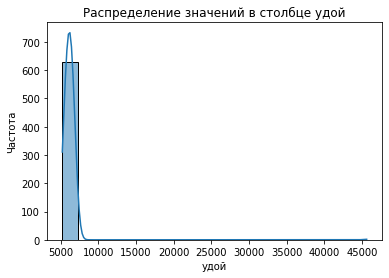

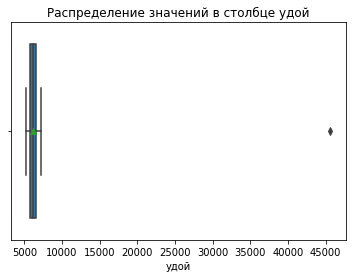

In [33]:
plot_distribution(ferma_main_df, 'удой')

Можно заметить аномально большое максимальное значение. Теперь точно видно, что это значение одиночный выброс. Избавимся от него.

In [36]:
ferma_main_df = ferma_main_df[ferma_main_df['удой'] != 45616]
ferma_main_df['удой'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой, dtype: float64

- данные распределены симметрично: мдиана находится по центру ящика, а усы примерно одинаковой длины.
- усы диаграммы размаха не содержат точек за пределами ящика, что говорит об отсутствии выбросов в данных.
- ящик диаграммы размаха узкий, что указывает на небольшой разброс данных.

Таким образом можно сделать вывод, что медиана близка к среднему значению, что может указывать на симметричное распределение данных. Разница между 75-м и 25-м процентилем (межквартильный размах) составляет 751.25, что говорит о том, что данные разбросаны относительно медианы.

Теперь рассмотрим столбец `эке`

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64


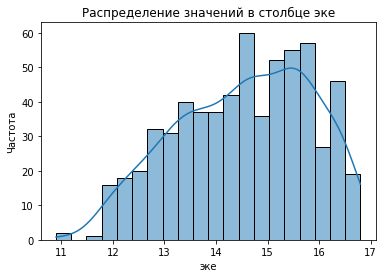

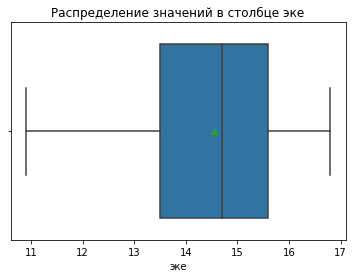

In [37]:
plot_distribution(ferma_main_df, 'эке')

- данные распределены не симметрично: медиана смещена вправо.
- отсутствие выбросов: усы диаграммы размаха не содержат точек за пределами ящика, что говорит об отсутствии выбросов в данных.
- малый разброс данных: ящик диаграммы размаха узкий, что указывает на небольшой разброс данных.

Теперь рассмотрим столбец `сырой_протеин`

count    628.000000
mean       1.923760
std        0.182833
min        1.660000
25%        1.771750
50%        1.888000
75%        2.062250
max        2.349000
Name: сырой_протеин, dtype: float64


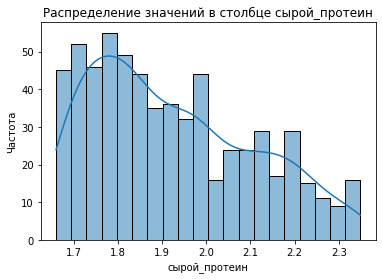

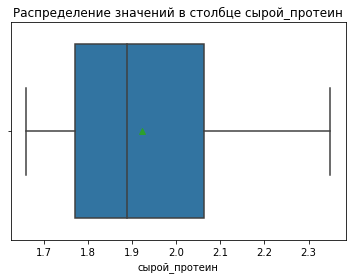

In [38]:
plot_distribution(ferma_main_df, 'сырой_протеин')

- медиана смещена влево, данные распределены несимметрично.
- разница между 75-м и 25-м процентилем составляет 0.29, что говорит о том, что данные разбросаны относительно медианы.

Теперь рассмотрим столбец `спо`

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64


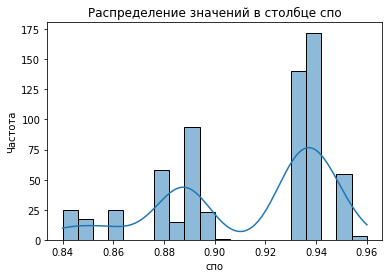

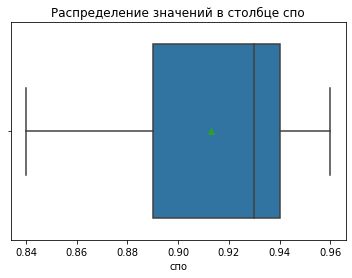

In [39]:
plot_distribution(ferma_main_df, 'спо')

- медиана смещена вправо относительно среднего значения, что может указывать на небольшую асимметрию вправо.
- разница между 75-м и 25-м процентилем составляет 0.05, что говорит о том, что данные разбросаны относительно медианы.
- гистограмма имеет несколько пиков и несимметрична, что говорит о том, что данные не следуют нормальному распределению.
- исходя из ящика с усами можно сделать вывод, что медиана смещена вправо, данные распределены несимметрично

Рассмотрим столбец `порода`

In [40]:
def analyze_categorical_feature(data, column_name):
    """
    Проводит анализ категориального признака в DataFrame.

    Args:
        data (pd.DataFrame): DataFrame с данными.
        column_name (str): Название столбца с категориальным признаком.

    Returns:
        None
    """

    # Проверка, является ли признак категориальным
    if not data[column_name].dtype.name == 'object':
        print(f"Столбец '{column_name}' не является категориальным.")
        return

    # Анализ столбца
    print(f"Анализ столбца '{column_name}':")
    print("Количество уникальных значений:", data[column_name].nunique())
    print("Список уникальных значений:", data[column_name].unique())

    # Частоты значений
    value_counts = data[column_name].value_counts()
    print("\nЧастоты значений:")
    print(value_counts)

    # Процентное соотношение значений
    value_percentages = value_counts / len(data) * 100
    print("\nПроцентное соотношение значений:")
    print(value_percentages)

    # Создание круговой диаграммы
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Процентное соотношение значений признака '{column_name}'")
    plt.axis('equal')  # Делаем круг
    plt.show()

Анализ столбца 'порода':
Количество уникальных значений: 2
Список уникальных значений: ['айдиал' 'соверин']

Частоты значений:
айдиал     372
соверин    256
Name: порода, dtype: int64

Процентное соотношение значений:
айдиал     59.235669
соверин    40.764331
Name: порода, dtype: float64


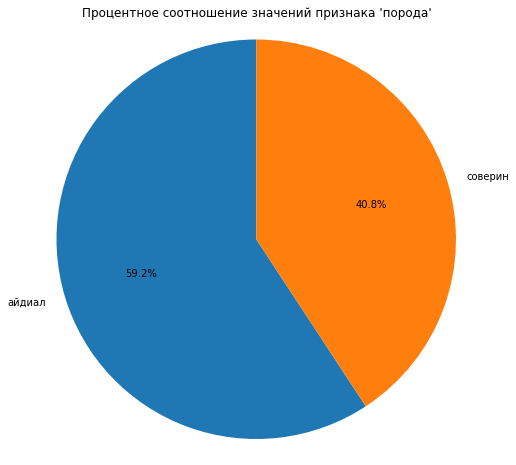

In [41]:
analyze_categorical_feature(ferma_main_df, 'порода')

Данные показывают, что в выборке преобладает одна порода, что может быть связано с различными факторами, например, с предпочтениями фермера, доступностью племенного материала или особенностями климата.

Рассмотрим столбец `тип_пастбища`

Анализ столбца 'тип_пастбища':
Количество уникальных значений: 2
Список уникальных значений: ['равнинное' 'холмистое']

Частоты значений:
холмистое    350
равнинное    278
Name: тип_пастбища, dtype: int64

Процентное соотношение значений:
холмистое    55.732484
равнинное    44.267516
Name: тип_пастбища, dtype: float64


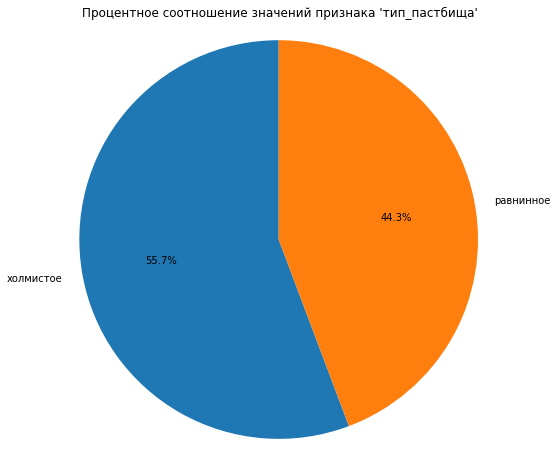

In [42]:
analyze_categorical_feature(ferma_main_df, 'тип_пастбища')

- преобладание холмистых пастбищ: холмистые пастбища составляют 55,73% от общего числа пастбищ, что говорит о том, что они являются более распространенным типом в данной выборке.
- значительное присутствие равнинных пастбищ: равнинные пастбища составляют 44,27% от общего числа, что свидетельствует о том, что они также играют важную роль в данной выборке.

Рассмотрим столбец `порода_папы_быка`

Анализ столбца 'порода_папы_быка':
Количество уникальных значений: 2
Список уникальных значений: ['айдиал' 'соверин']

Частоты значений:
айдиал     317
соверин    311
Name: порода_папы_быка, dtype: int64

Процентное соотношение значений:
айдиал     50.477707
соверин    49.522293
Name: порода_папы_быка, dtype: float64


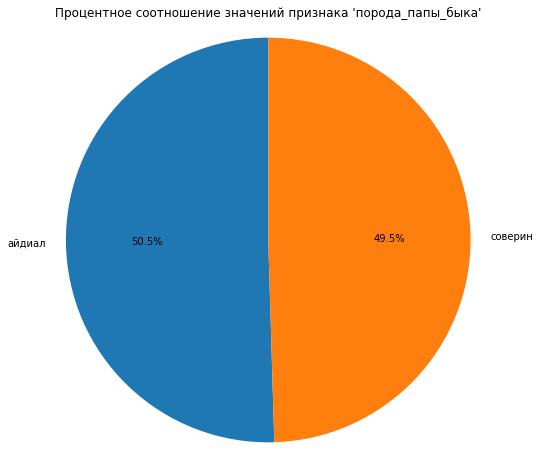

In [43]:
analyze_categorical_feature(ferma_main_df, 'порода_папы_быка')

- почти равное соотношение пород: породы `айдиал` и `соверин` практически одинаково представлены в выборке, составляя 50,48% и 49,52% соответственно.
- отсутствие явного преобладания: данные не показывают явного преобладания одной породы над другой, что может указывать на равномерное использование обоих типов отцов быков в данной выборке.

Рассмотрим столбец `жирность`

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64


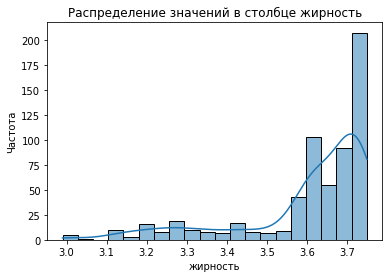

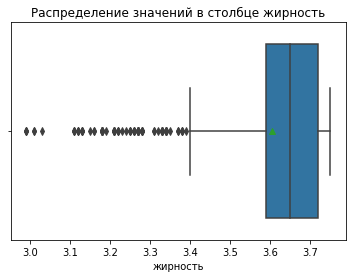

In [44]:
plot_distribution(ferma_main_df, 'жирность')

In [45]:
# Проверим долю выбросов по отношению ко всему датасету
print(f'Доля строк с выбросами признака "жирность": {round(len(ferma_main_df.query("жирность < 3.4")) / len(ferma_main_df) * 100, 3)}%')

Доля строк с выбросами признака "жирность": 13.694%


Исходя из графиков можно сделать вывод, что распределение смещено вправо. Доля выбросов слишком внушительная, поэтому избавляться от них не будем. 

Рассмотрим столбец `белок`

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


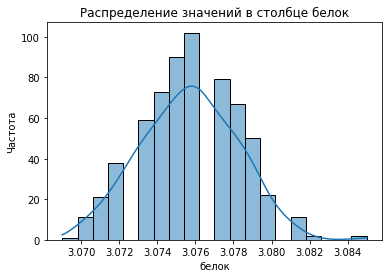

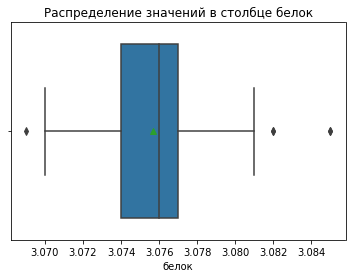

In [46]:
plot_distribution(ferma_main_df, 'белок')

Наблюдаются небольшие выбросы, поэтому избавимся от них.

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


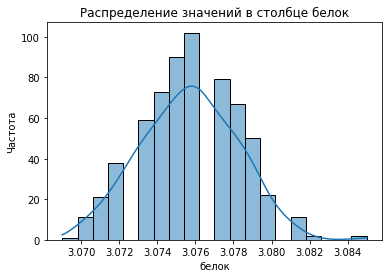

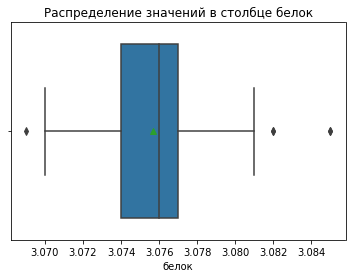

In [48]:
plot_distribution(ferma_main_df, 'белок')

Исходя из графиков, можно сделать вывод, что 
- распределение белков нормальное
- среднее содержание белка в молоке составляет 3.076%.
- стандартное отклонение 0.002466 указывает на то, что значения содержания белка в выборке очень близки друг к другу, т.е. белковый состав молока в данной выборке достаточно однороден.
- минимальное значение содержания белка составляет 3.070%, а максимальное - 3.081%. Это говорит о том, что диапазон изменения содержания белка в выборке очень узкий, что может указывать на определенные стандарты или ограничения, связанные с белковым составом молока.

Рассмотрим столбец `вкус_молока`

Анализ столбца 'вкус_молока':
Количество уникальных значений: 2
Список уникальных значений: ['вкусно' 'не вкусно']

Частоты значений:
вкусно       370
не вкусно    258
Name: вкус_молока, dtype: int64

Процентное соотношение значений:
вкусно       58.917197
не вкусно    41.082803
Name: вкус_молока, dtype: float64


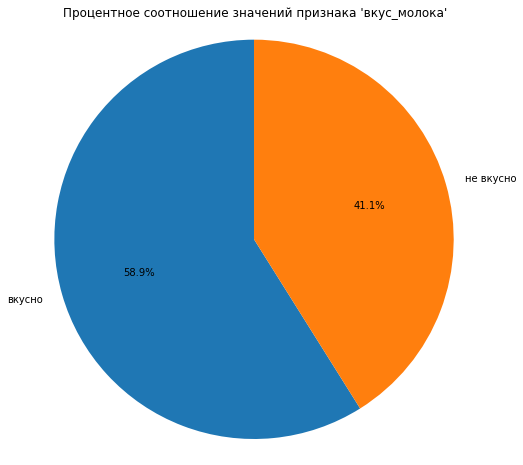

In [49]:
analyze_categorical_feature(ferma_main_df, 'вкус_молока')

- в выборке преобладает мнение о том, что молоко вкусное, оно составляет 58,75% от всех оценок.
- несмотря на преобладание положительных оценок, значительную часть (41,25%) оценили как невкусное молоко.

Рассмотрим столбец `возраст`

Анализ столбца 'возраст':
Количество уникальных значений: 2
Список уникальных значений: ['более_2_лет' 'менее_2_лет']

Частоты значений:
более_2_лет    518
менее_2_лет    110
Name: возраст, dtype: int64

Процентное соотношение значений:
более_2_лет    82.484076
менее_2_лет    17.515924
Name: возраст, dtype: float64


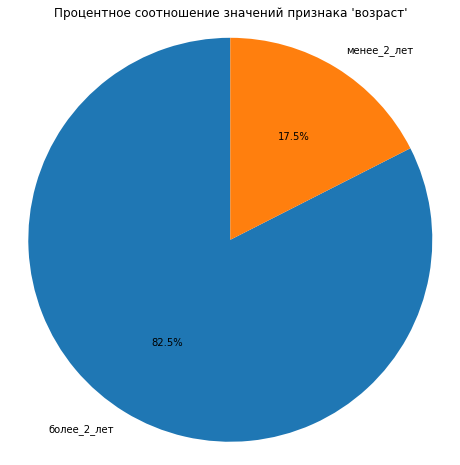

In [50]:
analyze_categorical_feature(ferma_main_df, 'возраст')

Из представленных данных можно сделать вывод, что в выборке преобладают коровы старше 2 лет (82,5%). Это говорит о том, что в выборке, скорее всего, представлены коровы, которые уже достигли пика своей продуктивности и находятся в стабильном периоде лактации

Теперь перейдем к данным из файла `ferma_dad.csv`

In [51]:
ferma_dad_df.head()

,id,имя_папы
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин


Анализ столбца 'имя_папы':
Количество уникальных значений: 4
Список уникальных значений: ['буйный' 'соловчик' 'барин' 'геркулес']

Частоты значений:
барин       240
буйный      215
соловчик    110
геркулес     64
Name: имя_папы, dtype: int64

Процентное соотношение значений:
барин       38.155803
буйный      34.181240
соловчик    17.488076
геркулес    10.174881
Name: имя_папы, dtype: float64


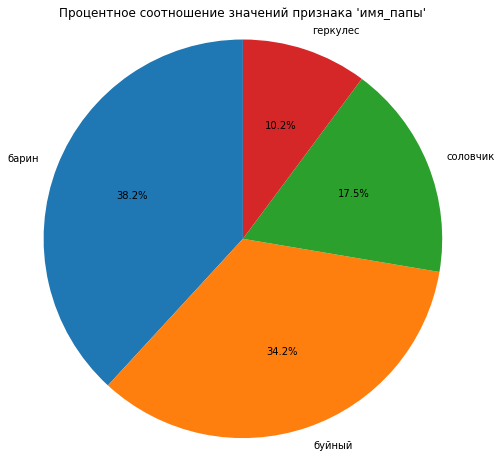

In [52]:
analyze_categorical_feature(ferma_dad_df, 'имя_папы')

В выборке преобладают коровы, чьи отцы - "барин" (38,16%) и "буйный" (34,18%). Это может указывать на то, что эти быки-производители наиболее популярны в данном регионе или что их потомство обладает ценными качествами. "Соловчик" и "Геркулес" менее распространены, что может говорить о том, что они менее популярны или их потомство обладает менее ценными качествами.

Теперь перейдем к данным из файла `cow_buy.csv`

In [53]:
cow_buy_df.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет
2,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет
3,соверин,холмистое,айдиал,буйный,3.40,3.061,более_2_лет
4,соверин,равнинное,айдиал,буйный,3.64,3.074,более_2_лет


Рассмотрим столбец `порода`

Анализ столбца 'порода':
Количество уникальных значений: 2
Список уникальных значений: ['айдиал' 'соверин']

Частоты значений:
соверин    11
айдиал      9
Name: порода, dtype: int64

Процентное соотношение значений:
соверин    55.0
айдиал     45.0
Name: порода, dtype: float64


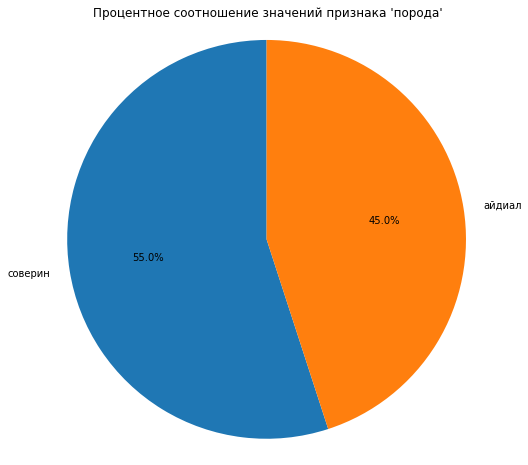

In [54]:
analyze_categorical_feature(cow_buy_df, 'порода')

- соотношение пород одинаковое: породы `айдиал` и `соверин` одинаково представлены в выборке.
- отсутствие явного преобладания: данные не показывают явного преобладания одной породы над другой, что может указывать на равномерное использование обоих типов пород коров.

Рассмотрим столбец `тип_пастбища`

Анализ столбца 'тип_пастбища':
Количество уникальных значений: 2
Список уникальных значений: ['холмистое' 'равнинное']

Частоты значений:
равнинное    11
холмистое     9
Name: тип_пастбища, dtype: int64

Процентное соотношение значений:
равнинное    55.0
холмистое    45.0
Name: тип_пастбища, dtype: float64


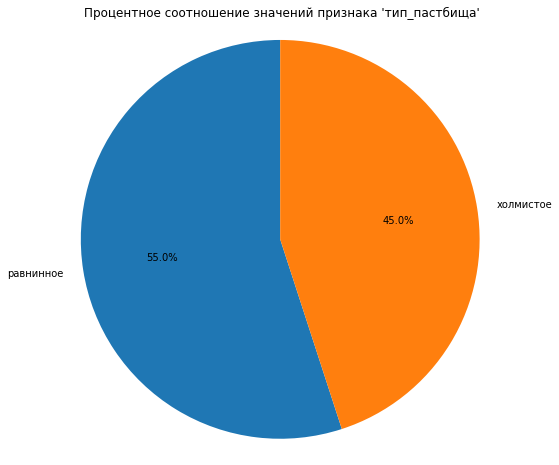

In [55]:
analyze_categorical_feature(cow_buy_df, 'тип_пастбища')

- соотношение типов пастбищ одинаковое: пастбища `холмистое` и `равнинное` одинаково представлены в выборке.
- отсутствие явного преобладания: данные не показывают явного преобладания одного пастбища над другим, что может указывать на равномерное использование обоих типов пастбищ.

Рассмотрим столбец `порода_папы_быка`

Анализ столбца 'порода_папы_быка':
Количество уникальных значений: 2
Список уникальных значений: ['айдиал' 'соверин']

Частоты значений:
соверин    12
айдиал      8
Name: порода_папы_быка, dtype: int64

Процентное соотношение значений:
соверин    60.0
айдиал     40.0
Name: порода_папы_быка, dtype: float64


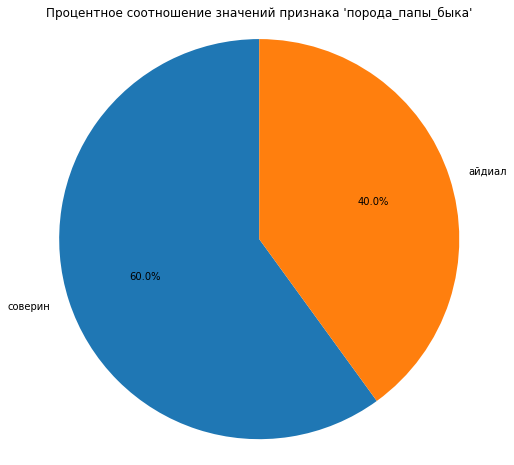

In [56]:
analyze_categorical_feature(cow_buy_df, 'порода_папы_быка')

Из представленных данных можно сделать вывод, что в выборке преобладают коровы, чьи отцы породы - `соверин` (62,5%). Это говорит о том, что `соверин` - наиболее популярная порода быков-производителей в "ЭкоФерме". `айдиал` менее распространен, что может говорить о том, что он менее популярен или его потомство обладает менее ценными качествами.

Рассмотрим столбец `имя_папы`

Анализ столбца 'имя_папы':
Количество уникальных значений: 4
Список уникальных значений: ['геркулес' 'буйный' 'барин' 'соловчик']

Частоты значений:
буйный      8
геркулес    6
барин       4
соловчик    2
Name: имя_папы, dtype: int64

Процентное соотношение значений:
буйный      40.0
геркулес    30.0
барин       20.0
соловчик    10.0
Name: имя_папы, dtype: float64


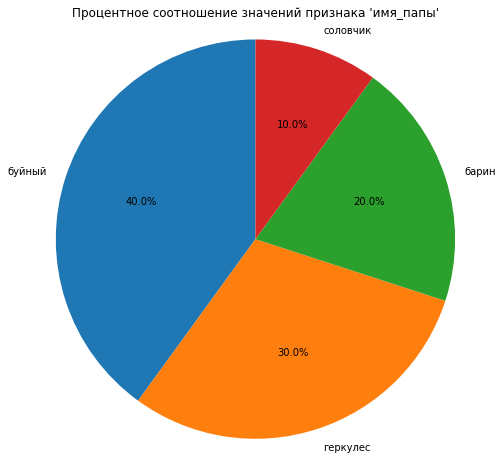

In [57]:
analyze_categorical_feature(cow_buy_df, 'имя_папы')

В выборке преобладают коровы, чьи отцы - "буйный" (43,8%) и "геркулес" (31,2%). Это может указывать на то, что эти быки-производители наиболее популярны в данном регионе или что их потомство обладает ценными качествами. "Соловчик" и "Барин" менее распространены, что может говорить о том, что они менее популярны или их потомство обладает менее ценными качествами.

Рассмотрим столбец `текущая_жирность`

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: текущая_жирность, dtype: float64


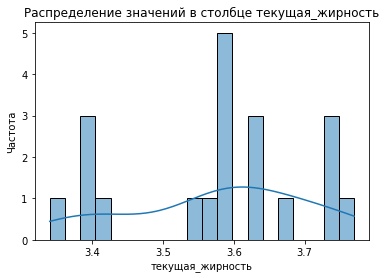

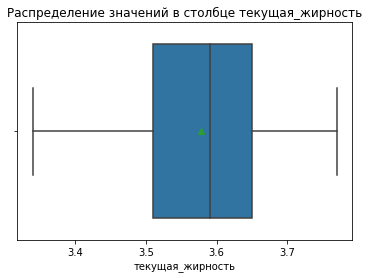

In [58]:
plot_distribution(cow_buy_df, 'текущая_жирность')

Гистограмма показывает, что распределение жирности молока не является нормальным. Данные сконцентрированы в нескольких узких диапазонах, что говорит о том, что жирность молока, скорее всего, контролируется и поддерживается на определенном уровне.

Из описательных статистик видно, что средняя жирность молока составляет 3.57%, а стандартное отклонение - 0.14%. Это говорит о том, что жирность молока в выборке варьируется в небольшом диапазоне.

Рассмотрим столбец `текущий_уровень_белок`

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: текущий_уровень_белок, dtype: float64


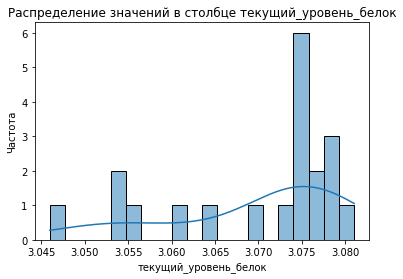

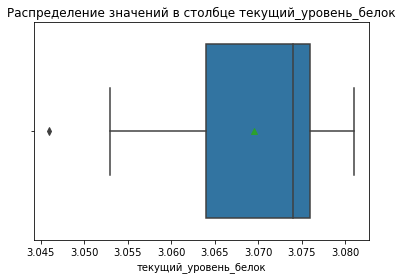

In [59]:
plot_distribution(cow_buy_df, 'текущий_уровень_белок')

Гистограмма показывает, что распределение белка не является нормальным. Данные сконцентрированы в нескольких узких диапазонах, что говорит о том, что белок, скорее всего, контролируется и поддерживается на определенном уровне.

Из описательных статистик видно, что средняя жирность молока составляет 3%, а стандартное отклонение - 0.01%. Это говорит о том, что белок в выборке варьируется в небольшом диапазоне.

Также можно заметить, что данные смещены вправо

Рассмотрим столбец `возраст`

Анализ столбца 'возраст':
Количество уникальных значений: 2
Список уникальных значений: ['более_2_лет' 'менее_2_лет']

Частоты значений:
более_2_лет    15
менее_2_лет     5
Name: возраст, dtype: int64

Процентное соотношение значений:
более_2_лет    75.0
менее_2_лет    25.0
Name: возраст, dtype: float64


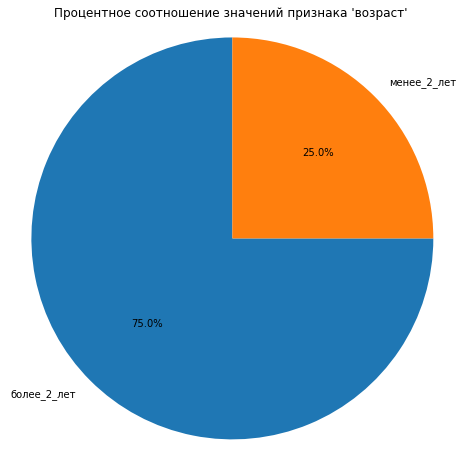

In [60]:
analyze_categorical_feature(cow_buy_df, 'возраст')

Из представленных данных можно сделать вывод, что в выборке преобладают коровы старше 2 лет (68,8%). Это говорит о том, что в выборке, скорее всего, представлены коровы, которые уже достигли пика своей продуктивности и находятся в стабильном периоде лактации

**Промежуточный вывод по результатам исследовательского анализа:**

в файле `ferma_main.csv`
- в столбце `удой` избавились от одиночного выброса
- данные распределены симметрично: мдиана находится по центру ящика, а усы примерно одинаковой длины.
- усы диаграммы размаха не содержат точек за пределами ящика, что говорит об отсутствии выбросов в данных.
- ящик диаграммы размаха узкий, что указывает на небольшой разброс данных.
- таким образом можно сделать вывод, что медиана близка к среднему значению, что может указывать на симметричное распределение данных. Разница между 75-м и 25-м процентилем (межквартильный размах) составляет 751.25, что говорит о том, что данные разбросаны относительно медианы.
- при рассмотрении ЭКЕ пришли к выводу, что данные распределены не симметрично: медиана смещена вправо.
- отсутствие выбросов: усы диаграммы размаха не содержат точек за пределами ящика, что говорит об отсутствии выбросов в данных.
- малый разброс данных: ящик диаграммы размаха узкий, что указывает на небольшой разброс данных.
- при рассмотрении данных о сыром протеине пришли к выводу, что медиана смещена влево, данные распределены несимметрично.
- разница между 75-м и 25-м процентилем составляет 0.29, что говорит о том, что данные разбросаны относительно медианы.
- при рассмотрении СПО сделали выводы, что медиана смещена вправо относительно среднего значения, что может указывать на небольшую асимметрию вправо.
- разница между 75-м и 25-м процентилем составляет 0.05, что говорит о том, что данные разбросаны относительно медианы.
- гистограмма имеет несколько пиков и несимметрична, что говорит о том, что данные не следуют нормальному распределению.
- исходя из ящика с усами можно сделать вывод, что медиана смещена вправо, данные распределены несимметрично 
- при рассмотрении данных о породах коров, пришли к выводу, что в выборке преобладает одна порода, что может быть связано с различными факторами, например, с предпочтениями фермера, доступностью племенного материала или особенностями климата.
- при рассмотрении данных о пастбищах на ферме пришли к выводу, что холмистые пастбища составляют 55,73% от общего числа пастбищ, что говорит о том, что они являются более распространенным типом в данной выборке.
- значительное присутствие равнинных пастбищ: равнинные пастбища составляют 44,27% от общего числа, что свидетельствует о том, что они также играют важную роль в данной выборке. 
- при рассмотрении пород отцов быков был сделан вывод, что породы айдиал и соверин практически одинаково представлены в выборке, составляя 50,48% и 49,52% соответственно.
- отсутствие явного преобладания: данные не показывают явного преобладания одной породы над другой, что может указывать на равномерное использование обоих типов отцов быков в данной выборке.
- при рассмотрении жирности заметили, что доля строк с выбросами слишком внушительная, поэтому от них не избавились
- при рассмотрении данных в столбце `белок` заметили небольшие выбросы и решили от них избавиться
- а также пришли к выводу, что распределение белков нормальное
- среднее содержание белка в молоке составляет 3.076%.
- стандартное отклонение 0.002466 указывает на то, что значения содержания белка в выборке очень близки друг к другу, т.е. белковый состав молока в данной выборке достаточно однороден.
- минимальное значение содержания белка составляет 3.070%, а максимальное - 3.081%. Это говорит о том, что диапазон изменения содержания белка в выборке очень узкий, что может указывать на определенные стандарты или ограничения, связанные с белковым составом молока.
- при рассмотрении вкуса молока пришли к выводу, что в выборке преобладает мнение о том, что молоко вкусное, оно составляет 58,75% от всех оценок.
- несмотря на преобладание положительных оценок, значительную часть (41,25%) оценили как невкусное молоко.
- также был рассмотрен и возраст коров. исходя из данных о возрасте выяснилось, что в выборке преобладают коровы старше 2 лет (82,5%). Это говорит о том, что в выборке, скорее всего, представлены коровы, которые уже достигли пика своей продуктивности и находятся в стабильном периоде лактации

в файле `ferma_dad.csv`
- В выборке преобладают коровы, чьи отцы - "барин" (38,16%) и "буйный" (34,18%). Это может указывать на то, что эти быки-производители наиболее популярны в данном регионе или что их потомство обладает ценными качествами. "Соловчик" и "Геркулес" менее распространены, что может говорить о том, что они менее популярны или их потомство обладает менее ценными качествами.

в файле `cow_buy.csv`
- было выявлено, что породы айдиал и соверин одинаково представлены в выборке.
отсутствие явного преобладания: данные не показывают явного преобладания одной породы над другой, что может указывать на равномерное использование обоих типов пород коров.
- также равномерно были представлены и пастбища
- однако исходя из распределения пород отцов быков, был сделан вывод, что в выборке преобладают коровы, чьи отцы породы - соверин (62,5%). Это говорит о том, что соверин - наиболее популярная порода быков-производителей в "ЭкоФерме". айдиал менее распространен, что может говорить о том, что он менее популярен или его потомство обладает менее ценными качествами.
- в выборке преобладают коровы, чьи отцы - "буйный" (43,8%) и "геркулес" (31,2%). Это может указывать на то, что эти быки-производители наиболее популярны в данном регионе или что их потомство обладает ценными качествами. "Соловчик" и "Барин" менее распространены, что может говорить о том, что они менее популярны или их потомство обладает менее ценными качествами.
- распределение жирности молока не является нормальным. Данные сконцентрированы в нескольких узких диапазонах, что говорит о том, что жирность молока, скорее всего, контролируется и поддерживается на определенном уровне.
- из описательных статистик видно, что средняя жирность молока составляет 3.57%, а стандартное отклонение - 0.14%. Это говорит о том, что жирность молока в выборке варьируется в небольшом диапазоне.
- распределение белка не является нормальным. Данные сконцентрированы в нескольких узких диапазонах, что говорит о том, что белок, скорее всего, контролируется и поддерживается на определенном уровне.
- из описательных статистик видно, что средняя жирность молока составляет 3%, а стандартное отклонение - 0.01%. Это говорит о том, что белок в выборке варьируется в небольшом диапазоне.
- также можно заметить, что данные смещены вправо
- в выборке преобладают коровы старше 2 лет (68,8%). Это говорит о том, что в выборке, скорее всего, представлены коровы, которые уже достигли пика своей продуктивности и находятся в стабильном периоде лактации

Почти все признаки распределены нормально и не требуют особых корректировок выбросов
Убрали аномальное значение признака `удой`
В признаке `белок` избавились от выбросов
Распределение категориальных переменных в норме, критических изменений не было внесено

## Корреляционный анализ

1. Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.
2. Постройте диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для Удой, кг и Сырой протеин, г, цвет точек диаграммы отображает признак Порода. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.
3. Сделайте выводы о взаимосвязи признаков.
    - Какой тип взаимосвязи между целевым и входными признаками?
    - Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
    - Наблюдается ли мультиколлинеарность между входными признаками?

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции.

In [61]:
ferma_main_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,соверин,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет


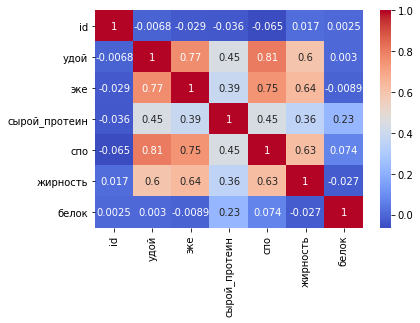

In [62]:
sns.heatmap(ferma_main_df.corr(), annot=True, cmap='coolwarm')
plt.show()

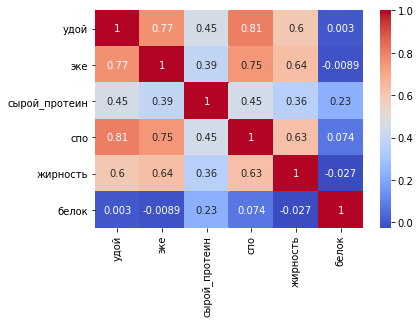

In [63]:
ferma_main = ferma_main_df.drop('id', axis=1)
sns.heatmap(ferma_main.corr(), annot=True, cmap='coolwarm')
plt.show()

Исходя из этой матрицы корреляции можно сделать вывод, что удой сильно коррелирует с СПО и с ЭКЕ, а также с жирностью

Построим диаграммы рассеяния scatterplot для признака `удой` и всех количественных признаков с учётом значения категориальных признаков.

In [64]:
def create_scatter_plots(data, quantitative_features, categorical_feature, figsize=(20, 10)):
    """
    Создает диаграммы рассеяния для заданных количественных признаков с учетом категориального признака.

    Args:
        data (pd.DataFrame): DataFrame с данными.
        quantitative_features (list): Список количественных признаков.
        categorical_feature (str): Название категориального признака.
        figsize (tuple, optional): Размер фигуры. Defaults to (20, 10).
    """

    plt.figure(figsize=figsize)

    for i, feature in enumerate(quantitative_features, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(data=data, x=feature, y='удой', hue=categorical_feature)
        plt.title(f'Удой и {feature}')

    plt.tight_layout()
    plt.show()

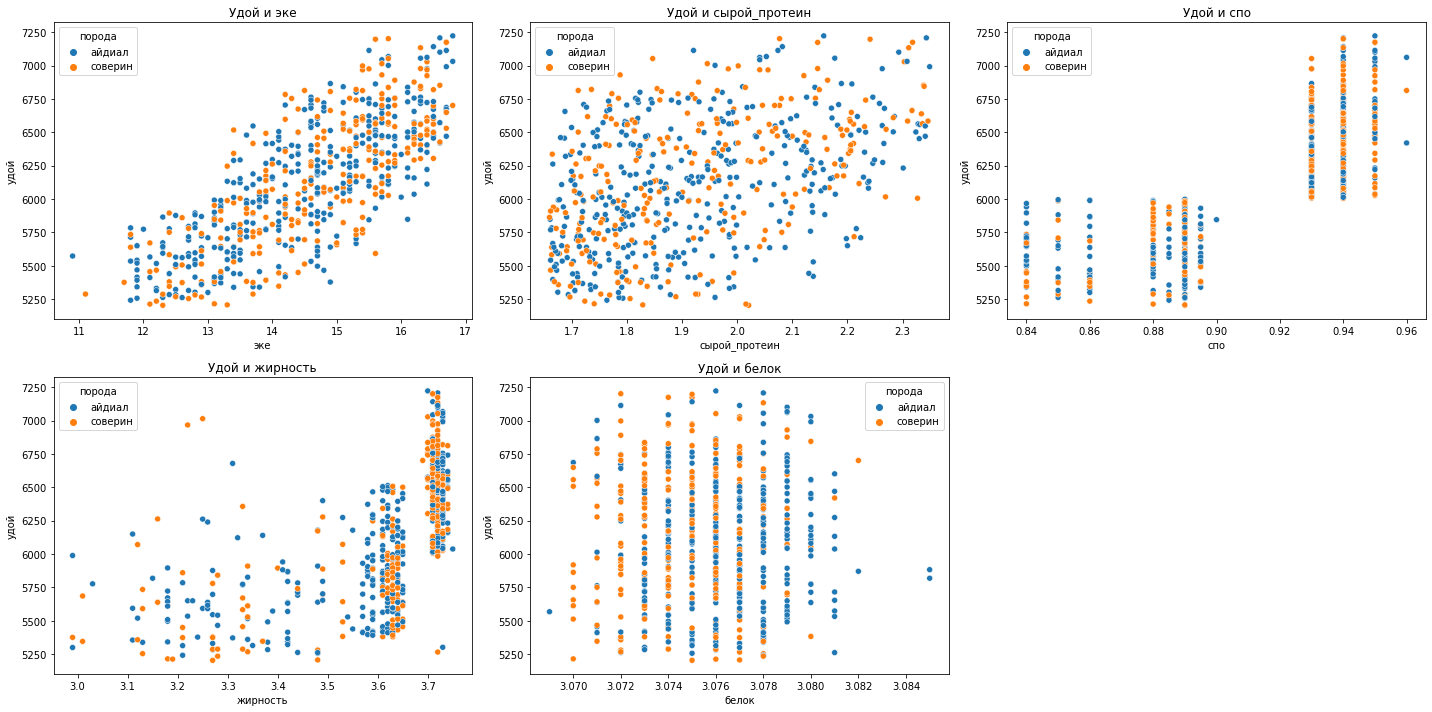

In [65]:
quantitative_scatter = ['эке', 'сырой_протеин', 'спо', 'жирность', 'белок']

create_scatter_plots(ferma_main_df, quantitative_scatter, 'порода')

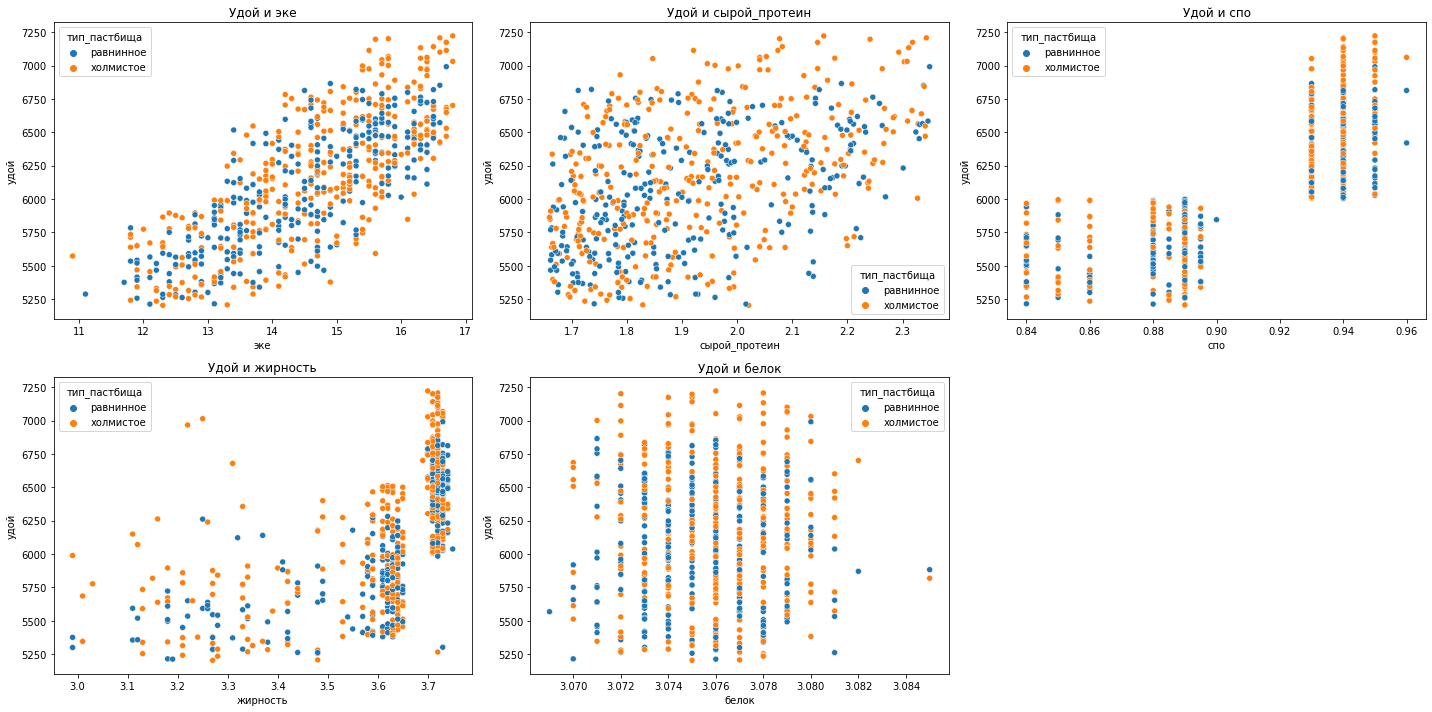

In [66]:
create_scatter_plots(ferma_main_df, quantitative_scatter, 'тип_пастбища')

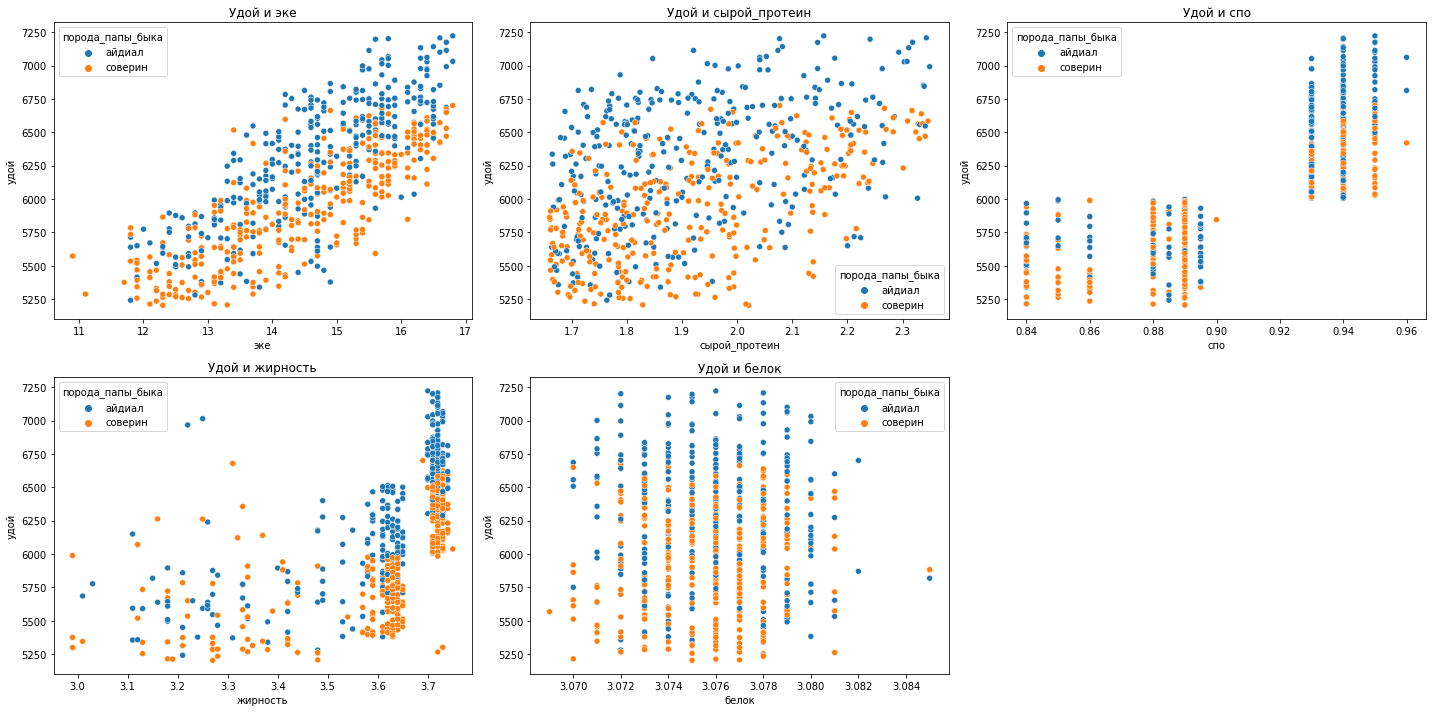

In [67]:
create_scatter_plots(ferma_main_df, quantitative_scatter, 'порода_папы_быка')

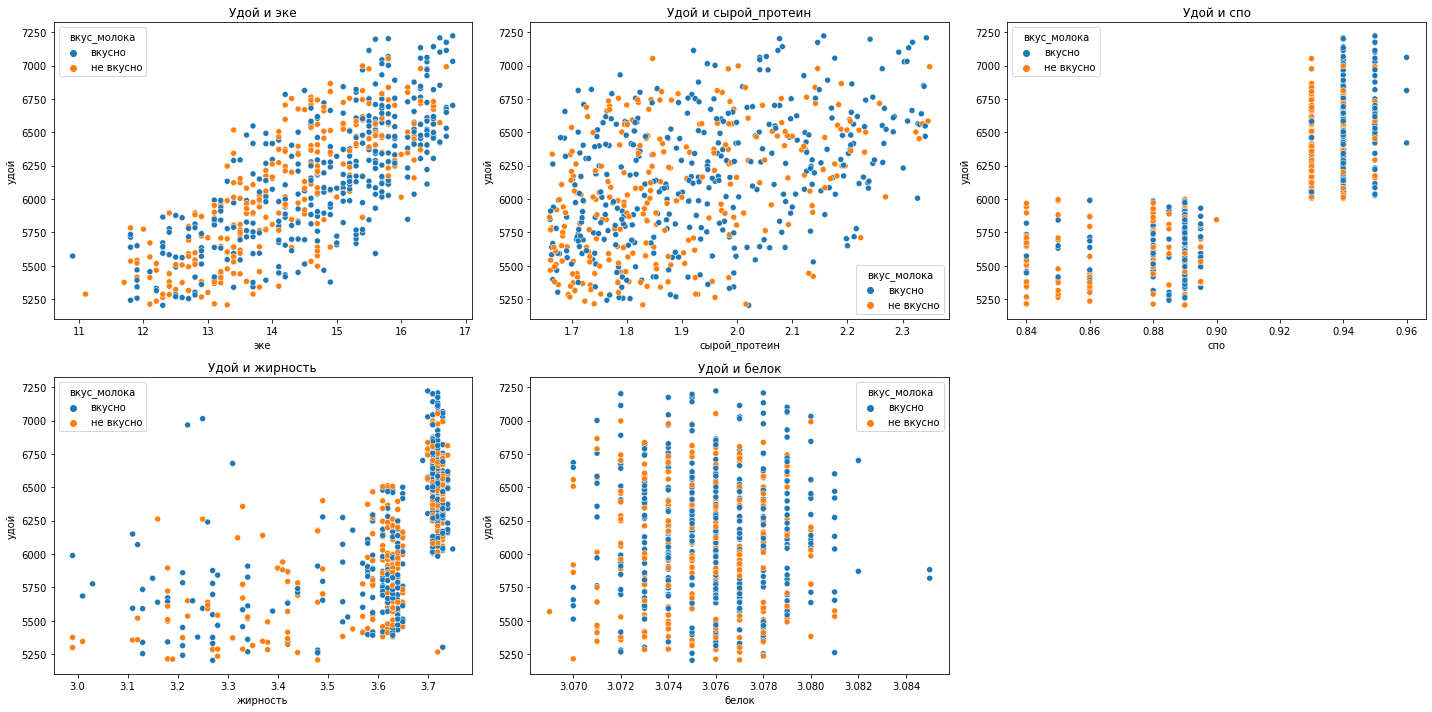

In [68]:
create_scatter_plots(ferma_main_df, quantitative_scatter, 'вкус_молока')

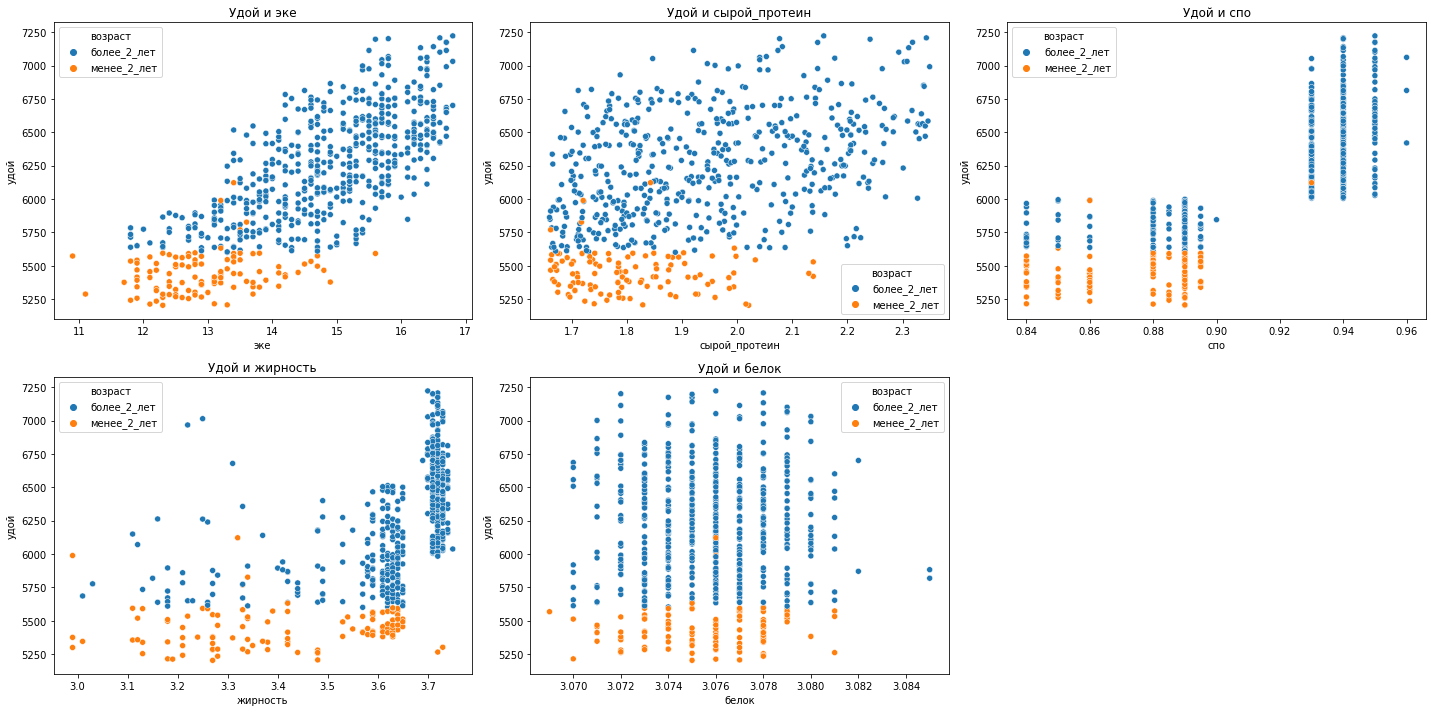

In [69]:
create_scatter_plots(ferma_main_df, quantitative_scatter, 'возраст')


- `эке`: Наблюдается положительная взаимосвязь выше умеренного значения. С увеличением `удоя` постепенно увеличивается и эке. По графикам распределения, корреляция справедлива как для одной, так и для другой породы. *Коэффициенты взаимосвязи: `0.76`*

- `сырой_протеин`: Взаимосвязь между содержанием сырого протеина и удоем не так ясна. На графике диаграмме рассеяния виден довольно большой разброс значений, однако наблюдается общий тренд на прямую пропорциональную зависимость. Связь умеренно положительная. *Коэффициенты взаимосвязи: `0.45`*

- `спо`: Похоже, что СПО сильно зависит от целевого признака - высокий коэффициент корреляции. В особенности видна резкая тенденция возвышения значений после. *Коэффициенты взаимосвязи: `0.81`*

- `жирность`: Умеренно положительная зависимость. Более всего связь раскрывается на переходе значений `жирность == 3.6 и 3.7`. *Коэффициент взаимосвязи: `0.6`*

- `белок`: Связь между этим признаком и целевым - нелинейная. Но стоит отметить, что наблюдается зависимость между признаком `белок` и `породой`. На меньших значения "белка" - больше значений с породой **РефлешнСоверинг**, а на бОльших значениях - больше значений породы `Вис Бик Айдиал`.  *Коэффициент взаимосвязи: `0.0023`*

1. Между целевым и входными признаками связь в основном **линейная**, но наличие нелинейных связей также возможно для отдельных пород.

2. Яркие нелинейные связи не выявлены, в связи с чем **добавление новых признаков - не требуется**. Но с признаком `спо` что-то явно не так: похоже на нелинейную связь

3. **Что касается мультиколлинеарности:** корреляционная матрица показала, что между некоторыми входными признаками есть сильная  корреляция. ~~Так как СПО является отношением сахара к протеину, то удалим этот столбец~~

## Обучение модели линейной регрессии

1. **`LinearRegression`**

Для обучения модели предстазывать удой нам не понадобится информация об `id` коровы, также о `белке`, значения `жирности` также никак не повлияет на информацию об удое

In [72]:
ferma_lr = ferma_main_df.drop(['id', 'белок', 'жирность'], axis=1)
ferma_lr.head()

,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст
0,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,вкусно,более_2_лет
1,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,вкусно,менее_2_лет
2,5810,14.0,1.854,0.885,соверин,холмистое,соверин,не вкусно,более_2_лет
3,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,не вкусно,более_2_лет
4,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,вкусно,менее_2_лет


In [73]:
def learn_lr_model(df, target, cat_col_names, num_col_names):
    """
    Обучает модель линейной регрессии и выводит метрики качества.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        target (str): Название целевой переменной.
        cat_col_names (list): Список названий категориальных признаков.
        num_col_names (list): Список названий количественных признаков.

    Returns:
        None
    """
    RANDOM_STATE = 42

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
    )
    
    # Разделяем признаки на категориальные и количественные
    cat_col_names = cat_col_names
    num_col_names = num_col_names

    # Кодируем категориальные признаки
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_valid_ohe = encoder.transform(X_valid[cat_col_names])
    encoder_col_names = encoder.get_feature_names()

    # Масштабируем количественные признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_valid_scaled = scaler.transform(X_valid[num_col_names])

    # Собираем выборки 
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
    
    
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_valid)
    r2 = r2_score(y_valid, predictions)
    print(f'R^2 = {r2}')
    mse = mean_squared_error(y_valid, predictions)
    print(f'MSE = {mse}')
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    print(f'RMSE = {rmse}')
    mae = mean_absolute_error(y_valid, predictions)
    print(f'MAE = {mae}')
    residuals = y_valid - predictions
    print(f'Среднее значение остатков модели: {residuals.mean()}')
    print('95% доверительный интервал =',
      st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))
    
    # Анализ остатков
    residuals = y_valid - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.title('Остатки от модели линейной регрессии')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.show()

    # Гистограмма остатков 
    sns.histplot(residuals, kde=True, bins=20, edgecolor='black')
    plt.title('Гистограмма остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.show()
    
    X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
    y_train_full = pd.concat([y_train, y_valid], ignore_index=True)
    
    # Сохранение модели, кодировщика и скейлера
    joblib.dump(model_lr, 'model_lr.pkl')
    joblib.dump(encoder, 'encoder.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    
    return X_train_full, y_train_full

R^2 = 0.7951757980652822
MSE = 41695.03139590991
RMSE = 204.1936125247553
MAE = 160.87314968758835
Среднее значение остатков модели: -28.090675249211504
95% доверительный интервал = (6108.330375391947, 6231.163077017304)


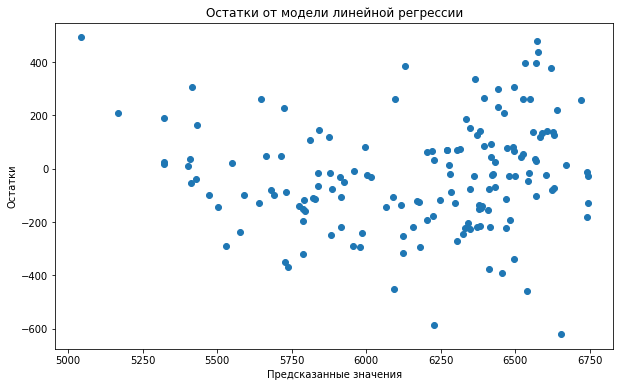

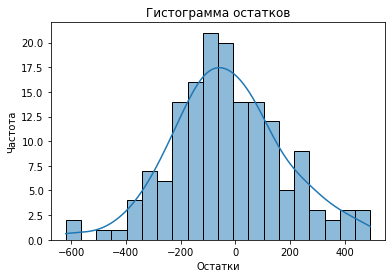

In [74]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']
num_col_names = ['эке', 'сырой_протеин', 'спо']
X_train_full, y_train_full = learn_lr_model(ferma_lr, 'удой', cat_col_names, num_col_names)

Сумма остатков прогнозной модели близка к нулю — модель хорошо работает.

**Вторая модель**

In [75]:
print(ferma_main_df.shape)
ferma_lr_2 = ferma_main_df.copy(deep=True)
ferma_lr_2.shape

(628, 12)


(628, 12)

In [76]:
# Преобразуем СПО в категориальный признак
ferma_lr_2['спо_кат'] = ferma_lr_2['спо'].apply(lambda x: 1 if x > 0.91 else 0)
print(ferma_lr_2['спо_кат'].value_counts())

# Преобразуем признак ЭКЕ 
ferma_lr_2['эке_в_квадрате'] = ferma_lr_2['эке'] ** 2

# Убираем неважные столбцы
ferma_lr_2 = ferma_lr_2.drop(['id', 'белок', 'жирность', 'эке', 'спо'], axis=1)
ferma_lr_2.head()

1    370
0    258
Name: спо_кат, dtype: int64


,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст,спо_кат,эке_в_квадрате
0,5863,1.743,айдиал,равнинное,айдиал,вкусно,более_2_лет,0,201.64
1,5529,2.138,айдиал,равнинное,соверин,вкусно,менее_2_лет,0,163.84
2,5810,1.854,соверин,холмистое,соверин,не вкусно,более_2_лет,0,196.00
3,5895,2.012,соверин,холмистое,айдиал,не вкусно,более_2_лет,0,153.76
4,5302,1.675,айдиал,равнинное,соверин,вкусно,менее_2_лет,0,163.84


R^2 = 0.8200973677186288
MSE = 36621.872954102175
RMSE = 191.3684220400591
MAE = 147.77939186178466
Среднее значение остатков модели: -25.601566488466958
95% доверительный интервал = (6104.19922618245, 6230.316008705314)


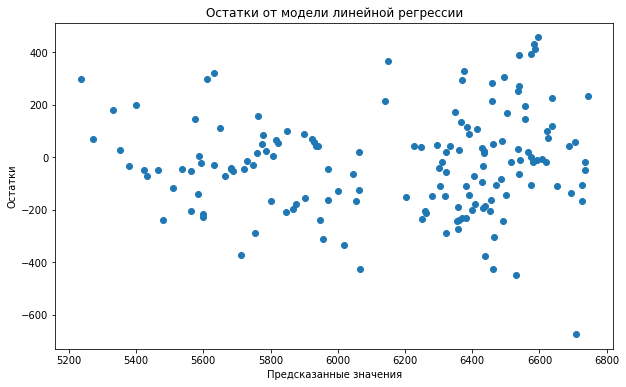

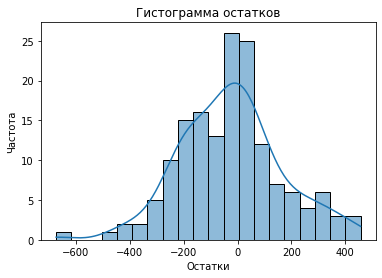

(     x0_соверин  x1_холмистое  x2_соверин  x3_не вкусно  x4_менее_2_лет  \
 0           1.0           1.0         1.0           0.0             0.0   
 1           1.0           1.0         1.0           0.0             1.0   
 2           0.0           0.0         0.0           1.0             0.0   
 3           0.0           1.0         0.0           0.0             0.0   
 4           0.0           0.0         0.0           0.0             0.0   
 ..          ...           ...         ...           ...             ...   
 623         0.0           1.0         0.0           0.0             0.0   
 624         1.0           1.0         0.0           0.0             0.0   
 625         0.0           0.0         0.0           0.0             0.0   
 626         0.0           0.0         0.0           1.0             0.0   
 627         0.0           0.0         0.0           1.0             1.0   
 
      эке_в_квадрате  сырой_протеин   спо_кат  
 0          1.577968       1.079523  0

In [77]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']
num_col_names = ['эке_в_квадрате', 'сырой_протеин', 'спо_кат']
learn_lr_model(ferma_lr_2, 'удой', cat_col_names, num_col_names)

Остатки распределены нормально, график симметричен, отклонение от средней суммы минимально. Значение R^2 увеличилось по сравнению с прошлой моделью.

**Третья модель**

Добавим признак `Имя Папы` из файла `ferma_dad.csv`, соединив его с остальными данными `ferma_main.csv` по ключу.

Устраним нелинейность между признаками.

In [78]:
ferma_full_df = ferma_main_df.merge(ferma_dad_df, on='id')
ferma_full_df.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,буйный
1,2,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,соловчик
2,3,5810,14.0,1.854,0.885,соверин,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,барин
3,4,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,буйный
4,5,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,барин


In [79]:
# Преобразуем СПО в категориальный признак
ferma_full_df['спо_кат'] = ferma_full_df['спо'].apply(lambda x: 1 if x > 0.91 else 0)

# Преобразуем признак ЭКЕ 
ferma_full_df['эке_в_квадрате'] = ferma_full_df['эке'] ** 2

# Убираем неважные столбцы
ferma_full_df = ferma_full_df.drop(['id', 'белок', 'жирность', 'эке', 'спо', 'вкус_молока'], axis=1)
ferma_full_df.head()

,удой,сырой_протеин,порода,тип_пастбища,порода_папы_быка,возраст,имя_папы,спо_кат,эке_в_квадрате
0,5863,1.743,айдиал,равнинное,айдиал,более_2_лет,буйный,0,201.64
1,5529,2.138,айдиал,равнинное,соверин,менее_2_лет,соловчик,0,163.84
2,5810,1.854,соверин,холмистое,соверин,более_2_лет,барин,0,196.00
3,5895,2.012,соверин,холмистое,айдиал,более_2_лет,буйный,0,153.76
4,5302,1.675,айдиал,равнинное,соверин,менее_2_лет,барин,0,163.84


R^2 = 0.8247542745210406
MSE = 35673.88988618197
RMSE = 188.87532895055926
MAE = 146.16302445362322
Среднее значение остатков модели: -15.201522000921058
95% доверительный интервал = (6092.340075854288, 6221.3750700583805)


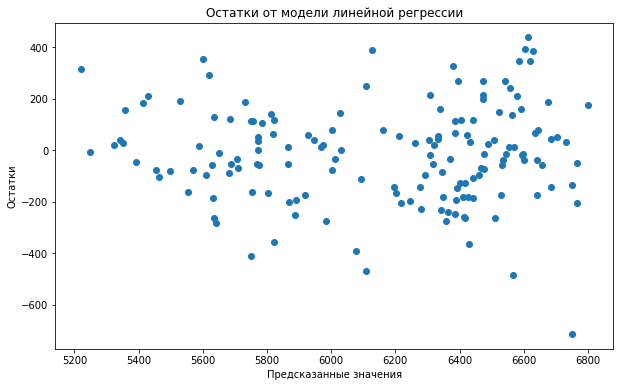

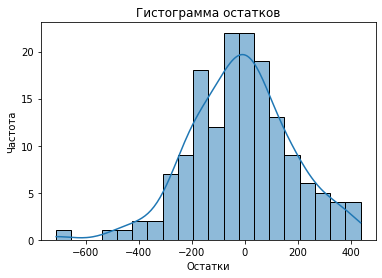

(     x0_соверин  x1_холмистое  x2_соверин  x3_менее_2_лет  x4_буйный  \
 0           1.0           1.0         1.0             0.0        0.0   
 1           1.0           1.0         1.0             1.0        0.0   
 2           0.0           0.0         0.0             0.0        1.0   
 3           0.0           1.0         0.0             0.0        1.0   
 4           0.0           0.0         0.0             0.0        0.0   
 ..          ...           ...         ...             ...        ...   
 623         0.0           1.0         0.0             0.0        0.0   
 624         1.0           1.0         0.0             0.0        1.0   
 625         0.0           0.0         0.0             0.0        1.0   
 626         0.0           0.0         0.0             0.0        0.0   
 627         0.0           0.0         0.0             1.0        1.0   
 
      x4_геркулес  x4_соловчик  эке_в_квадрате  сырой_протеин   спо_кат  
 0            0.0          1.0        1.577968  

In [80]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
num_col_names = ['эке_в_квадрате', 'сырой_протеин', 'спо_кат']
learn_lr_model(ferma_full_df, 'удой', cat_col_names, num_col_names)

Остатки распределены нормально, график симметричен, отклонение от средней суммы минимально. Значение R^2 увеличилось по сравнению с прошлой моделью.

- На данном этапе третья модель показывает наилучшее значение R^2 == 0.8429312454588963
- MSE = 34413.594943172706
- RMSE = 185.50901580023734
- MAE = 145.55800402481063
- Среднее значение остатков модели: 16.130387097122075
- По условию задачи регрессии, можем на данном этапе рекомендовать фермеру для покупки всех коров. Каждая из них, вероятно, выдает более 6000 кг удоя в год, однако еще стоит предсказать, молоко каких коров будет вкусным

**Прогнозирование удоя**

In [81]:
# Загрузка модели, кодировщика и скейлера
model_lr = joblib.load('model_lr.pkl')
encoder = joblib.load('encoder.pkl')
scaler = joblib.load('scaler.pkl')

In [88]:
cow_buy_ml = cow_buy_df.copy(deep=True)

# Считаем среднее значение недостающих признаков и увеличиваем их на 5%
mean_values = ferma_main_df[['эке', 'сырой_протеин', 'спо']].mean()
new_values = mean_values * 1.05

# Добавляем недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_ml['эке'] = new_values['эке']
cow_buy_ml['эке_в_квадрате'] = cow_buy_ml['эке'] ** 2
cow_buy_ml['сырой_протеин'] = new_values['сырой_протеин']
cow_buy_ml['спо'] = new_values['спо']
cow_buy_ml['спо_кат'] = cow_buy_ml['спо'].apply(lambda x: 1 if x > 0.91 else 0)


cow_buy_ml = cow_buy_ml.drop(['текущий_уровень_белок', 'эке', 'спо'], axis=1)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
num_col_names = ['эке_в_квадрате', 'сырой_протеин', 'спо_кат']


X_test_ohe = encoder.transform(cow_buy_ml[cat_col_names])
encoder_col_names = encoder.get_feature_names()


X_test_scaled = scaler.transform(cow_buy_ml[num_col_names])


X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test_full = pd.concat([X_test_ohe_df, X_test_scaled_df], axis=1)


pred = model_lr.predict(X_test_full)

cow_buy_df['ожидаемый_удой'] = pred
cow_buy_df

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,ожидаемый_удой
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6378.711028
2,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет,6283.999775
3,соверин,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6593.089377
4,соверин,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6542.146066
5,соверин,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,6425.380218
6,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297
7,айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,6571.259737
8,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет,6283.999775
9,соверин,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,6400.540668


- На данном этапе третья модель показывает наилучшее значение R^2 == 0.8429312454588963
- MSE = 34413.594943172706
- RMSE = 185.50901580023734
- MAE = 145.55800402481063
- Среднее значение остатков модели: 16.130387097122075
- По условию задачи регрессии, можем на данном этапе рекомендовать фермеру для покупки всех коров. Каждая из них, вероятно, выдает более 6000 кг удоя в год, однако еще стоит предсказать, молоко каких коров будет вкусным

## Обучение модели логистической регрессии

In [89]:
ferma_full_df = ferma_main_df.merge(ferma_dad_df, on='id')
ferma_log = ferma_full_df.copy(deep=True)
ferma_log.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1.743,0.890,айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,буйный
1,2,5529,12.8,2.138,0.890,айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,соловчик
2,3,5810,14.0,1.854,0.885,соверин,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,барин
3,4,5895,12.4,2.012,0.885,соверин,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,буйный
4,5,5302,12.8,1.675,0.885,айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,барин


In [90]:
ferma_log['вкус_молока_кат'] = ferma_log['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_log['спо_кат'] = ferma_log['спо'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_log['эке_в_квадрате'] = ferma_log['эке'] ** 2

ferma_log = ferma_log.drop(['id', 'удой', 'вкус_молока', 'эке', 'спо'], axis=1)

ferma_log.head()

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,имя_папы,вкус_молока_кат,спо_кат,эке_в_квадрате
0,1.743,айдиал,равнинное,айдиал,3.58,3.076,более_2_лет,буйный,1,0,201.64
1,2.138,айдиал,равнинное,соверин,3.54,3.079,менее_2_лет,соловчик,1,0,163.84
2,1.854,соверин,холмистое,соверин,3.59,3.074,более_2_лет,барин,0,0,196.00
3,2.012,соверин,холмистое,айдиал,3.40,3.075,более_2_лет,буйный,0,0,153.76
4,1.675,айдиал,равнинное,соверин,3.73,3.073,менее_2_лет,барин,1,0,163.84


In [91]:
def plot_conf_matr(y_valid, y_pred):
    # Построение матрицы ошибок
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted')
    plt.show()

In [92]:
RANDOM_STATE = 42

X = ferma_log.drop('вкус_молока_кат', axis=1)
y = ferma_log['вкус_молока_кат']

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

# Заранее создадим объединенную тренировочную выборку
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

In [93]:
# Разделяем признаки на категориальные и количественные
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_в_квадрате', 'сырой_протеин']

In [94]:
# Кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = encoder.transform(X_valid[cat_col_names])
encoder_col_names = encoder.get_feature_names()

In [95]:
# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names])

In [96]:
# Собираем выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

In [97]:
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

clf_accuracy = accuracy_score(y_pred, y_valid)
clf_recall = recall_score(y_pred, y_valid)
clf_precision = precision_score(y_pred, y_valid)

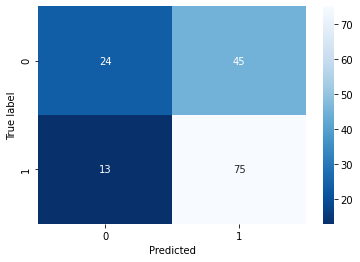

Old Accuracy: 0.6305732484076433
Old Recall: 0.625
Old Precision: 0.8522727272727273


In [98]:
# Построение матрицы ошибок
plot_conf_matr(y_valid, y_pred)

print(f'Old Accuracy: {clf_accuracy}')
print(f'Old Recall: {clf_recall}')
print(f'Old Precision: {clf_precision}')

Метрика precision имеет неплохое значение - 0.8045977011494253, однако стоит обратить внимание на ошибки первого рода. recall и accuracy близки к показателям "случайной модели", что не совсем хорошо
Имеем целых 41 ошибку первого рода, по отношению к 70 верноположительным предсказаниям. Больше половины ошибок: нужно минимизировать их количество

LogisticRegression: ROC AUC=0.728


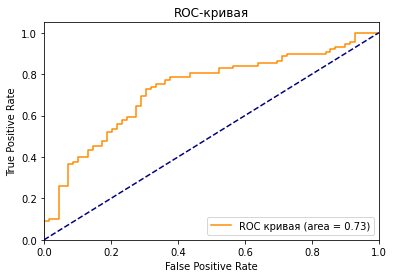

Оптимальный порог: 0.6039046010114777


In [99]:
y_proba = clf.predict_proba(X_valid)[:,1]

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_valid, y_proba)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую

fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

print(f'Оптимальный порог: {optimal_threshold}')


In [100]:
# Выделяем оптимальный порог
OPTIMAL_THRESHOLD = optimal_threshold

# Применение порога к предсказанным вероятностям
y_pred_threshold = (y_proba > OPTIMAL_THRESHOLD).astype(int)

clf_accuracy_new = accuracy_score(y_valid, y_pred_threshold)
clf_recall_new = recall_score(y_valid, y_pred_threshold)
clf_precision_new = precision_score(y_valid, y_pred_threshold)


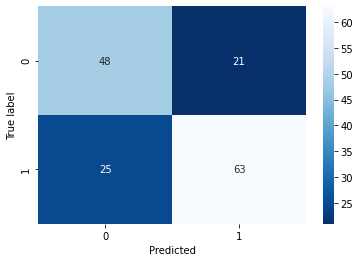

New Accuracy: 0.7070063694267515
New Recall: 0.7159090909090909
New Precision: 0.75


In [101]:
# Построение матрицы ошибок
plot_conf_matr(y_valid, y_pred_threshold)

print(f'New Accuracy: {clf_accuracy_new}')
print(f'New Recall: {clf_recall_new}')
print(f'New Precision: {clf_precision_new}')

Исходя из матрицы ошибок можно сделать вывод, что ошибки первого рода критичны, так как мы будем рекомендовать фермеру приобрести коров с невкусным молоком.

Мы снизили количество ошибок первого рода с 41 до 10

**Прогноз вкуса молока**

In [102]:
cow_buy_ml_2 = cow_buy_df.copy(deep=True)
cow_buy_ml_2.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,ожидаемый_удой
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6378.711028
2,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет,6283.999775
3,соверин,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6593.089377
4,соверин,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6542.146066


Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.

In [103]:
# Считаем среднее значение каждого недостающего признака и увеличиваем их на 5%
mean_values = ferma_main_df[['эке', 'сырой_протеин', 'спо']].mean()
new_values = mean_values * 1.05

# Добавляем недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_ml_2['эке'] = new_values['эке']
cow_buy_ml_2['эке_в_квадрате'] = cow_buy_ml_2['эке'] ** 2
cow_buy_ml_2['сырой_протеин'] = new_values['сырой_протеин']
cow_buy_ml_2['спо'] = new_values['спо']
cow_buy_ml_2['спо_кат'] = cow_buy_ml_2['спо'].apply(lambda x: 1 if x > 0.91 else 0)

# Форматируем cow_buy
cow_buy_ml_2.rename(columns={'текущая_жирность': 'жирность', 'текущий_белок': 'белок'}, inplace=True)
cow_buy_ml_2 = cow_buy_ml_2.drop(['имя_папы', 'эке', 'спо'], axis=1)

# Подготовка признаков

cow_buy_ml_2.head()

,порода,тип_пастбища,порода_папы_быка,жирность,текущий_уровень_белок,возраст,ожидаемый_удой,эке_в_квадрате,сырой_протеин,спо_кат
0,айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,6609.919297,233.361138,2.019948,1
1,айдиал,равнинное,соверин,3.54,3.081,менее_2_лет,6378.711028,233.361138,2.019948,1
2,соверин,равнинное,соверин,3.59,3.074,более_2_лет,6283.999775,233.361138,2.019948,1
3,соверин,холмистое,айдиал,3.40,3.061,более_2_лет,6593.089377,233.361138,2.019948,1
4,соверин,равнинное,айдиал,3.64,3.074,более_2_лет,6542.146066,233.361138,2.019948,1


In [104]:
cow_buy_ml_2 = cow_buy_ml_2.rename(columns={'текущий_уровень_белок': 'белок'})
cow_buy_ml_2.head()

,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,ожидаемый_удой,эке_в_квадрате,сырой_протеин,спо_кат
0,айдиал,холмистое,айдиал,3.58,3.076,более_2_лет,6609.919297,233.361138,2.019948,1
1,айдиал,равнинное,соверин,3.54,3.081,менее_2_лет,6378.711028,233.361138,2.019948,1
2,соверин,равнинное,соверин,3.59,3.074,более_2_лет,6283.999775,233.361138,2.019948,1
3,соверин,холмистое,айдиал,3.40,3.061,более_2_лет,6593.089377,233.361138,2.019948,1
4,соверин,равнинное,айдиал,3.64,3.074,более_2_лет,6542.146066,233.361138,2.019948,1


In [105]:
X_train_full.head()

,сырой_протеин,порода,тип_пастбища,порода_папы_быка,жирность,белок,возраст,имя_папы,спо_кат,эке_в_квадрате
0,2.123,соверин,холмистое,соверин,3.70,3.074,более_2_лет,соловчик,1,272.25
1,1.889,соверин,холмистое,соверин,3.34,3.072,менее_2_лет,барин,0,156.25
2,1.671,айдиал,равнинное,айдиал,3.18,3.079,более_2_лет,буйный,0,216.09
3,2.063,айдиал,холмистое,айдиал,3.62,3.079,более_2_лет,буйный,1,207.36
4,2.077,айдиал,равнинное,айдиал,3.64,3.076,более_2_лет,геркулес,0,171.61


In [107]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_кат']
num_col_names = ['жирность', 'белок', 'эке_в_квадрате', 'сырой_протеин']

X_test_ohe = encoder.transform(cow_buy_ml_2[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_test_scaled = scaler.transform(cow_buy_ml_2[num_col_names])

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [109]:
y_proba = clf.predict_proba(X_test_full)[:, 1]
predictions_final = (y_proba > OPTIMAL_THRESHOLD).astype(int)

cow_buy_df['ожидаемый_вкус_молока'] = predictions_final
cow_buy_df['ожидаемый_вкус_молока'] = cow_buy_df['ожидаемый_вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
to_buy = cow_buy_df.query('ожидаемый_вкус_молока == "вкусно"')
cow_buy_df

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,ожидаемый_удой,ожидаемый_вкус_молока
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6378.711028,вкусно
2,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет,6283.999775,не вкусно
3,соверин,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6593.089377,не вкусно
4,соверин,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6542.146066,не вкусно
5,соверин,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,6425.380218,не вкусно
6,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
7,айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,6571.259737,вкусно
8,соверин,равнинное,соверин,барин,3.59,3.074,более_2_лет,6283.999775,не вкусно
9,соверин,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,6400.540668,вкусно


In [110]:
to_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,ожидаемый_удой,ожидаемый_вкус_молока
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6378.711028,вкусно
6,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
7,айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,6571.259737,вкусно
9,соверин,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,6400.540668,вкусно
13,айдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет,6127.474742,вкусно
16,айдиал,холмистое,соверин,соловчик,3.73,3.079,более_2_лет,6344.707860,вкусно


Таким образом, 7 номинанта на продажу представлены выше

## Итоговые выводы

В ходе работы над проектом была разработана модель машинного обучения, которая сможет помочь заказчику управлять рисками и принимать объективное решение о покупке коров на ферму. Рекомендуемые коровы к покупке:


In [111]:
to_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,ожидаемый_удой,ожидаемый_вкус_молока
0,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
1,айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6378.711028,вкусно
6,айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
7,айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,6571.259737,вкусно
9,соверин,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,6400.540668,вкусно
13,айдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет,6127.474742,вкусно
16,айдиал,холмистое,соверин,соловчик,3.73,3.079,более_2_лет,6344.707860,вкусно


В ходе работы были проделаны следующие шаги:
1. **Загрузка и подготовка данных**

Предоставленные данные соответствуют описанию.

Для удобства работы с данными названия столбцов были приведены к нижнему регистру и вместо пробелов поставлен знак нижнее подчеркивание. Также для удобства были переименованы некоторые столбцы, которые имели очень длинное название. Все строковые значения были приведены к нижнему регистру.

В файле `ferma_main.csv`:
- было 634 выявлено строки без пропусков
- выявлено, что некоторые типы не соответствуют признакам, а именно: неправильный тип у столбцов `эке`, `спо`, `жирность`, `белок` должен быть тип `float`. Преобразование этих столбцов к нужному типу данных.
- в столбце `сырой_протеин` все значения разделили на 1000, чтобы привести к одинаковым единицами измерения, а именно к кг
- в столбце `тип_пастбища` есть два типа, которые описывают одно и то же. Переименовали `Равнинные` в `Равнинное`.
- аналогичная ситуация и с породой_папы_быка. Переименовали `Айдиалл` в `Айдиал`
- переименовали породы в соответствии с породами из столбца `порода_папы_быка`
- удалили дубликаты

В файле `ferma_dad.csv`:
- в этих данных пропусков и дубликатов найдено не было.

В файле `cow_buy.csv`:
- переопределили тип данных в столбцах `текущая_жирность`, `текущий_уровень_белок` на `float`.
- пропусков обнаружено не было
- удалили дубликаты

2. **Исследовательский анализ**

- Выявили, что почти все признаки распределены нормально и не требуют особых корректировок выбросов
- Убрали аномальное значение признака `удой`
- В признаке `белок` избавились от выбросов, перезаписали датафрейм с условием, в которое входят данные из диапазона:
- В распределение категориальных переменных критических изменений внесено не было

3. **Корреляционный анализ**


- `эке`: Наблюдается положительная взаимосвязь выше умеренного значения. С увеличением `удоя` постепенно увеличивается и эке. По графикам распределения, корреляция справедлива как для одной, так и для другой породы. *Коэффициенты взаимосвязи: `0.76`*

- `сырой_протеин`: Взаимосвязь между содержанием сырого протеина и удоем не так ясна. На графике диаграмме рассеяния виден довольно большой разброс значений, однако наблюдается общий тренд на прямую пропорциональную зависимость. Связь умеренно положительная. *Коэффициенты взаимосвязи: `0.45`*

- `спо`: Похоже, что СПО сильно зависит от целевого признака - высокий коэффициент корреляции. В особенности видна резкая тенденция возвышения значений после. *Коэффициенты взаимосвязи: `0.81`*

- `жирность`: Умеренно положительная зависимость. Более всего связь раскрывается на переходе значений `жирность == 3.6 и 3.7`. *Коэффициент взаимосвязи: `0.6`*

- `белок`: Связь между этим признаком и целевым - нелинейная. Но стоит отметить, что наблюдается зависимость между признаком `белок` и `породой`. На меньших значения "белка" - больше значений с породой **РефлешнСоверинг**, а на бОльших значениях - больше значений породы `Вис Бик Айдиал`.  *Коэффициент взаимосвязи: `0.0023`*

1. Между целевым и входными признаками связь в основном **линейная**, но наличие нелинейных связей также возможно для отдельных пород.

2. Яркие нелинейные связи не выявлены, в связи с чем **добавление новых признаков - не требуется**. Но с признаком `спо` что-то явно не так: похоже на нелинейную связь

3. Что касается мультиколлинеарности: корреляционная матрица показала, что между некоторыми входными признаками есть сильная  корреляция. 

4. **Предсказание удоя**

- Третья модель показывает наилучшее значение R^2 == 0.8429312454588963
- MSE = 34413.594943172706
- RMSE = 185.50901580023734
- MAE = 145.55800402481063
- Среднее значение остатков модели: 16.130387097122075
- По условию задачи регрессии, можем на данном этапе рекомендовать фермеру для покупки всех коров. Каждая из них, вероятно, выдает более 6000 кг удоя в год, однако еще стоит предсказать, молоко каких коров будет вкусным

5. **Предсказание вкуса молока**

- Подобрали параметры и обучили модель логистической регрессии
- Проанализировали модель и минимизировали количество критических ошибок первого рода с 42 до 9, подобрав новый порог для вероятности предсказаний
- Определили 4-х коров, чье молоко предсказано как "вкусное"
- Отобрали для рекомендации 4 коровы, учитывая оба условия заказчика